In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from matplotlib import pyplot
from keras.callbacks import ReduceLROnPlateau
import keras
import texthero as hero
from texthero import preprocessing as str_preprocessing
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Read in and Prepare Data

In [54]:
def encode_and_bind(original_dataframe, feature_to_encode): # utility function for one-hot encoding
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res)
    

In [64]:
labels = pd.read_csv ("./gilani-2017/gilani-2017.tsv", sep = '\t')
labels['id'] = labels['461277906']
df = pd.read_json("./gilani-2017/gilani-2017_tweets.json")
df = pd.json_normalize(df['user'])
df.columns = df.columns.map(lambda x: x.split(".")[-1])

labels = set(labels['id'])
bot = []
for id in df.id:
    if id in labels:
        bot.append(1)
    else:
        bot.append(0)
df['bot'] = bot
df = df.drop(['lang', 'is_translator', 'is_translation_enabled',  'profile_background_tile',  'profile_background_color', 'profile_background_image_url', 'time_zone', 'profile_background_image_url_https', 'id', 'created_at', 'profile_image_url', 'profile_image_url_https', 'utc_offset' , 'url', 'profile_banner_url','protected','name','translator_type', 'urls', 'id_str', 'profile_sidebar_border_color', 'profile_sidebar_fill_color', 'profile_text_color', 'profile_link_color'], axis = 1)
df = df.dropna(axis = 1)
df

,screen_name,location,description,followers_count,friends_count,listed_count,favourites_count,geo_enabled,verified,statuses_count,contributors_enabled,profile_use_background_image,has_extended_profile,default_profile,default_profile_image,following,follow_request_sent,notifications,bot
0,BaseballQuotes1,The Diamond,Quoting America's Pastime in 280 characters or...,121500,346,532,35894,True,False,21246,False,False,False,False,False,False,False,False,1
1,cavs,"The Q | Cleveland, OH",Official Twitter of the 2016 NBA Champion Clev...,3227215,1946,9039,16134,True,True,45791,False,True,False,False,False,False,False,False,1
2,muohajer_12,المملكة العربية السعودية,,864968,767106,1371,23,True,False,875763,False,True,False,True,False,False,False,False,1
3,Bc20_,,R.I.P JRL21//R.I.P Monica💙 IG//b.20c #GLOHIOBOYS,951,275,9,22147,True,False,88862,False,False,True,False,False,False,False,False,1
4,_Blkahontas,"Hollywood, FL",to die for 🔮🤞🏾👸🏾,1412,623,12,5582,True,False,142073,False,True,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2489,BigMacFlashy,"Phoenix, AZ",CEO of @thebambox and @comiconauction. Love De...,331,154,1,350,False,False,325,False,False,False,False,False,False,False,False,1
2490,BadruulAminn,"Petaling, Selangor",20 / YouTuber + Streamer / Married /\n\nCome s...,71105,62028,27,1818,False,False,27006,False,True,True,False,False,False,False,False,1
2491,anxietyhes,,woke up the girl who looked just like you I al...,99769,67170,335,27192,True,False,81781,False,True,True,False,False,False,False,False,1
2492,EN_owl,なごやちほー,旧型クロスカブ改(プラウダ戦車色)に乗るガルパンおじさん。ノンナと愛里寿推し。日本一周201...,1222,244,102,382,False,False,70120,False,True,False,False,False,False,False,False,1


In [65]:
data = np.asarray(df.drop(['bot'], axis = 1))


custom_pipeline = [str_preprocessing.fillna,
                   str_preprocessing.remove_whitespace,
                   str_preprocessing.remove_diacritics,
                   str_preprocessing.remove_brackets
                  ]

string_cols = ['screen_name', 'location', 'description' ]
for ftr in string_cols:
    df[ftr] = hero.clean(df[ftr], custom_pipeline)
df

,screen_name,location,description,followers_count,friends_count,listed_count,favourites_count,geo_enabled,verified,statuses_count,contributors_enabled,profile_use_background_image,has_extended_profile,default_profile,default_profile_image,following,follow_request_sent,notifications,bot
0,BaseballQuotes1,The Diamond,Quoting America's Pastime in 280 characters or...,121500,346,532,35894,True,False,21246,False,False,False,False,False,False,False,False,1
1,cavs,"The Q | Cleveland, OH",Official Twitter of the 2016 NBA Champion Clev...,3227215,1946,9039,16134,True,True,45791,False,True,False,False,False,False,False,False,1
2,muohajer_12,lmmlk@ l`rby@ ls`wdy@,,864968,767106,1371,23,True,False,875763,False,True,False,True,False,False,False,False,1
3,Bc20_,,R.I.P JRL21//R.I.P Monica IG//b.20c #GLOHIOBOYS,951,275,9,22147,True,False,88862,False,False,True,False,False,False,False,False,1
4,_Blkahontas,"Hollywood, FL",to die for,1412,623,12,5582,True,False,142073,False,True,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2489,BigMacFlashy,"Phoenix, AZ",CEO of @thebambox and @comiconauction. Love De...,331,154,1,350,False,False,325,False,False,False,False,False,False,False,False,1
2490,BadruulAminn,"Petaling, Selangor",20 / YouTuber + Streamer / Married / Come supp...,71105,62028,27,1818,False,False,27006,False,True,True,False,False,False,False,False,1
2491,anxietyhes,,woke up the girl who looked just like you I al...,99769,67170,335,27192,True,False,81781,False,True,True,False,False,False,False,False,1
2492,EN_owl,nagoyachiho,Jiu Xing kurosukabuGai niCheng rugarupanozisan...,1222,244,102,382,False,False,70120,False,True,False,False,False,False,False,False,1


In [66]:
for ftr in string_cols: #vector encoding
    tokens = [TaggedDocument(doc.split(' '), [i]) 
                for i, doc in enumerate(df[ftr])]
    model = Doc2Vec(vector_size=64, window=2, min_count=1, workers=8, epochs = 40)
    model.build_vocab(tokens)
    model.train(tokens, total_examples=model.corpus_count, epochs=model.epochs)
    card2vec = [model.infer_vector((df[ftr][i].split(' '))) 
            for i in range(0,len(df[ftr]))]
    df[ftr] = card2vec
df

,screen_name,location,description,followers_count,friends_count,listed_count,favourites_count,geo_enabled,verified,statuses_count,contributors_enabled,profile_use_background_image,has_extended_profile,default_profile,default_profile_image,following,follow_request_sent,notifications,bot
0,"[-0.0070288726, -0.0040792087, 0.0012606132, -...","[0.066174775, -0.056987915, 0.16336717, 0.0835...","[-0.08186332, -0.06750497, 0.22465733, -0.0256...",121500,346,532,35894,True,False,21246,False,False,False,False,False,False,False,False,1
1,"[0.0039677653, -0.002443526, 0.0012238534, -0....","[0.10792271, -0.08283845, 0.25550935, 0.126634...","[-0.3253888, -0.16326976, 0.49476528, -0.07801...",3227215,1946,9039,16134,True,True,45791,False,True,False,False,False,False,False,False,1
2,"[-0.007003172, 0.0013219216, 0.007862511, -0.0...","[0.03370163, -0.05195676, 0.066781804, 0.02382...","[0.031721994, -0.008191645, 0.047364075, -0.00...",864968,767106,1371,23,True,False,875763,False,True,False,True,False,False,False,False,1
3,"[0.0006012096, 0.0025059464, 0.0014174102, -0....","[-0.0066773654, 0.009096071, -0.016422326, -0....","[-0.16700467, -0.1083699, 0.41241193, -0.01533...",951,275,9,22147,True,False,88862,False,False,True,False,False,False,False,False,1
4,"[-0.0073499437, -0.001446563, 0.006734952, 0.0...","[0.061717056, -0.04596635, 0.13230109, 0.07118...","[-0.050167657, 0.014984792, -0.1844358, -0.050...",1412,623,12,5582,True,False,142073,False,True,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2489,"[0.0019886277, -0.0064980513, 0.0028957142, 0....","[0.079094194, -0.06358572, 0.20361824, 0.09864...","[-0.2385665, -0.1531389, 0.39934692, -0.090960...",331,154,1,350,False,False,325,False,False,False,False,False,False,False,False,1
2490,"[0.0065088933, 0.004966373, 0.0057712267, -0.0...","[0.0975155, -0.0750072, 0.2436012, 0.120846465...","[-0.016036723, -0.08832745, 0.23119536, -0.054...",71105,62028,27,1818,False,False,27006,False,True,True,False,False,False,False,False,1
2491,"[1.7614074e-07, -0.0057578837, -0.004165435, -...","[-0.0073086154, 0.009272801, -0.01811443, -0.0...","[-0.1666293, -0.06301393, 0.23734869, -0.02801...",99769,67170,335,27192,True,False,81781,False,True,True,False,False,False,False,False,1
2492,"[-0.0046433685, -0.0039980914, -0.0042391513, ...","[0.03868941, -0.037328515, 0.10683024, 0.05772...","[-0.066906646, -0.3624938, 2.0543358, 0.074390...",1222,244,102,382,False,False,70120,False,True,False,False,False,False,False,False,1


In [67]:
data = df.copy()
data = data.drop(['screen_name', 'location', 'description'] ,axis = 1)
ftr_count = len(data.keys())
data = np.asarray(data.drop(['bot'], axis = 1))

# idx =int(698*.7)
# X_train, X_test, Y_train, Y_test = np.array(data[:idx:]), np.array(data[idx:,:]), np.array(df.bot[:idx:]), np.array(df.bot[idx:,:])


X_train, X_test, Y_train, Y_test = train_test_split(data, np.array(df.bot),test_size = 0.3, random_state = 78)
X_train, X_test, Y_train, Y_test = X_train.astype(np.float), X_test.astype(np.float), Y_train.astype(np.float), Y_test.astype(np.float)



In [68]:
#RANDOM FORREST
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 3, criterion = 'entropy')
rf.fit(X_train, Y_train)
y_predict_forest = rf.predict(X_test)
y_predict_forest = [1 if i > 0.5 else 0 for i in y_predict_forest]
print("ACC: ", sum([1 if i==j else 0  for i,j in zip(y_predict_forest,Y_test) ])/len(y_predict_forest))
# print(classification_report(Y_test, y_predict_forest))

ACC:  0.9959946595460614


In [69]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=100) # tuned to 100
knn.fit(X_train, Y_train)
y_predict_knn = knn.predict(X_test)
y_predict_knn = [1 if i > 0.5 else 0 for i in y_predict_knn]
print("ACC: ", sum([1 if i==j else 0  for i,j in zip(y_predict_knn,Y_test) ])/len(y_predict_knn))

ACC:  0.9959946595460614


In [70]:
#MODELS
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve,
]

def create_model(idim = ftr_count-1):
  model = Sequential()

  model.add(Dense(32, input_dim=idim))
  model.add(Dropout(.3))
  model.add(Activation('gelu'))

  model.add(Dense(64, input_dim=32))
  model.add(Dropout(.3))
  model.add(Activation('gelu'))

  model.add(Dense(128, input_dim=64))
  model.add(Dropout(.5))
  model.add(Activation('gelu'))


  model.add(Dense(64, input_dim=128))
  model.add(Dropout(.3))
  model.add(Activation('gelu'))
  
  model.add(Dense(32, input_dim=64))
  model.add(Dropout(.1))
  model.add(Activation('gelu'))

  model.add(Dense(1, input_dim=64))
  model.add(Activation('sigmoid'))

  optimizer = tf.keras.optimizers.SGD(
    learning_rate=1e-3, nesterov=False,
  )
  #tfa.losses.SigmoidFocalCrossEntropy()
  model.compile(optimizer = optimizer, loss= tf.keras.losses.BinaryCrossentropy(),  metrics=METRICS)
  return model


# class_weight = compute_class_weight(class_weight = 'balanced', classes = [0,1], y = np.array(df.bot).astype(np.float))
# class_weight = {0: class_weight[0],
#                 1: class_weight[1]}
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                512       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 activation_1 (Activation)   (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8

2021-12-17 00:35:01.923900: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [72]:

history = model.fit(x=X_train.astype(np.float), y=Y_train.astype(np.float), batch_size=8, epochs=50, validation_data=(X_test.astype(np.float), Y_test.astype(np.float)), verbose=1, shuffle=True, callbacks=
                                [ModelCheckpoint(filepath='./ckpts/best_val_loss.hdf5',
                                               monitor= 'val_loss',
                                               save_best_only=True,
                                               mode='auto',
                                               save_weights_only=True,
                                               verbose=2),
                                EarlyStopping(monitor='val_loss',
                                             mode='auto',
                                             patience=100,
                                             verbose=1),  
                                ReduceLROnPlateau(
                                monitor='loss', factor=0.1, patience=10, verbose=1,
                                mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
                            )])

Epoch 1/50


InvalidArgumentError:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (sequential/activation_5/Sigmoid:0) = ] [[-nan][-nan][-nan]...] [y (Cast_2/x:0) = ] [0]
	 [[node assert_greater_equal/Assert/AssertGuard/Assert
 (defined at /Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/keras/utils/metrics_utils.py:608)
]] [Op:__inference_train_function_3525]

Errors may have originated from an input operation.
Input Source operations connected to node assert_greater_equal/Assert/AssertGuard/Assert:
In[0] assert_greater_equal/Assert/AssertGuard/Assert/assert_greater_equal/All:	
In[1] assert_greater_equal/Assert/AssertGuard/Assert/data_0:	
In[2] assert_greater_equal/Assert/AssertGuard/Assert/data_1:	
In[3] assert_greater_equal/Assert/AssertGuard/Assert/data_2:	
In[4] assert_greater_equal/Assert/AssertGuard/Assert/sequential/activation_5/Sigmoid:	
In[5] assert_greater_equal/Assert/AssertGuard/Assert/data_4:	
In[6] assert_greater_equal/Assert/AssertGuard/Assert/Cast_2/x:

Operation defined at: (most recent call last)
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/asyncio/events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2901, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3172, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/var/folders/_2/fbtf2s8s6l3679y1xrlyxs180000gn/T/ipykernel_5298/2166851920.py", line 1, in <module>
>>>     history = model.fit(x=X_train.astype(np.float), y=Y_train.astype(np.float), batch_size=8, epochs=50, validation_data=(X_test, Y_test), verbose=1, shuffle=True, callbacks=
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/keras/engine/training.py", line 817, in train_step
>>>     self.compiled_metrics.update_state(y, y_pred, sample_weight)
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 460, in update_state
>>>     metric_obj.update_state(y_t, y_p, sample_weight=mask)
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 73, in decorated
>>>     update_op = update_state_fn(*args, **kwargs)
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/keras/metrics.py", line 177, in update_state_fn
>>>     return ag_update_state(*args, **kwargs)
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/keras/metrics.py", line 1069, in update_state
>>>     return metrics_utils.update_confusion_matrix_variables(
>>> 
>>>   File "/Users/sanjay/miniconda3/envs/stonks/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 608, in update_confusion_matrix_variables
>>>     tf.compat.v1.assert_greater_equal(
>>> 

Function call stack:
train_function -> assert_greater_equal_Assert_AssertGuard_false_2557


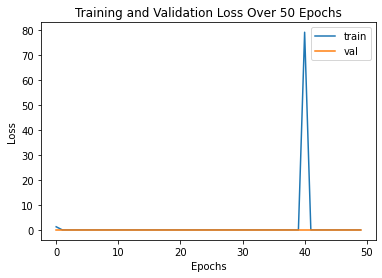

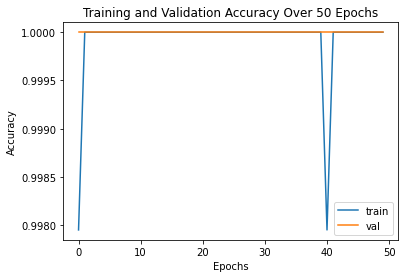

array([[210]])

In [ ]:
history.history['loss']
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.xlabel("Epochs")
pyplot.ylabel("Loss")
pyplot.title("Training and Validation Loss Over %d Epochs" % (len(history.history['loss']),))
pyplot.legend()
pyplot.show()

history.history['accuracy']
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='val')
pyplot.xlabel("Epochs")
pyplot.ylabel("Accuracy")
pyplot.title("Training and Validation Accuracy Over %d Epochs" % (len(history.history['loss']),))
pyplot.legend()
pyplot.show()
 
from sklearn.metrics import log_loss # The data is binary
from math import sqrt

model.built = True
model.load_weights("ckpts/best_val_loss.hdf5")
y_pred = model.predict(X_test)
y_pred = [1 if i > 0.5 else 0 for i in y_pred] # roc curve when you change threshold
confusion_matrix(y_pred, Y_test)

